## Feature Importance (Model-based)

### Subtask:
Train a Random Forest model and extract feature importance scores to rank variables.

**Reasoning**:
Train a Random Forest Classifier on the encoded dataset to get feature importance scores. These scores indicate the contribution of each feature to the model's predictive performance, helping us rank features by relevance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Separate features and target
X = df_encoded.drop('num', axis=1)
y = df_encoded['num']

# Initialize and train a Random Forest Classifier
# We use a simple model for feature importance calculation
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Create a pandas Series for easier viewing and sorting
feature_importance_series = pd.Series(feature_importances, index=X.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("Feature Importances (Random Forest):")
display(sorted_feature_importances)

Feature Importances (Random Forest):


,0
thalach,0.145161
oldpeak,0.119441
age,0.114960
chol,0.110535
trestbps,0.096552
thal_7.0,0.060592
cp_4,0.058923
exang_1,0.047135
slope_2,0.034934
ca_1.0,0.034681


## Recursive Feature Elimination (RFE)

### Subtask:
Apply Recursive Feature Elimination (RFE) to select a subset of the most relevant features.

**Reasoning**:
RFE is a feature selection method that fits a model and removes the weakest features (according to the model's `coef_` or `feature_importances_`) until the specified number of features is reached. We will use a RandomForestClassifier with RFE to select a subset of features. We'll start by selecting a reasonable number of features (e.g., half of the original features) and can adjust this later if needed.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Re-initialize a Random Forest Classifier
model_rfe = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE
# We'll select half of the features to start
num_features_to_select = len(X.columns) // 2
rfe = RFE(estimator=model_rfe, n_features_to_select=num_features_to_select)

# Fit RFE
rfe.fit(X, y)

# Get the selected features
selected_features_mask = rfe.support_
selected_features = X.columns[selected_features_mask]

print(f"Selected features using RFE ({num_features_to_select} features):")
display(selected_features)

# You can also see the ranking of features
# print("\nFeature ranking by RFE:")
# display(rfe.ranking_)

Selected features using RFE (10 features):


Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp_4', 'exang_1',
       'slope_2', 'ca_1.0', 'thal_7.0'],
      dtype='object')

## Chi-Square Test

### Subtask:
Use Chi-Square Test to check feature significance for categorical features.

**Reasoning**:
The Chi-Square test is used to determine if there is a significant association between two categorical variables. We will apply it to each original categorical feature and the target variable ('num') to assess their statistical dependence. Features with low p-values are considered more significant.

In [ ]:
from sklearn.feature_selection import chi2

# We need to use the original categorical features before one-hot encoding
# Let's redefine the categorical columns based on the variable information
categorical_cols_original = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Create a DataFrame with only the original categorical features and the target
X_cat = df[categorical_cols_original]
y = df['num']

# Perform Chi-Square test for each categorical feature
chi2_stats, p_values = chi2(X_cat, y)

# Create a DataFrame to display the results
chi2_results = pd.DataFrame({'Chi2 Statistic': chi2_stats, 'P-value': p_values}, index=X_cat.columns)

# Sort the results by P-value
chi2_results_sorted = chi2_results.sort_values(by='P-value')

print("Chi-Square Test Results (sorted by P-value):")
display(chi2_results_sorted)

Chi-Square Test Results (sorted by P-value):


,Chi2 Statistic,P-value
ca,109.866875,7.769316e-23
thal,70.294698,1.966875e-14
exang,41.534482,2.083076e-08
cp,16.881183,2.038435e-03
restecg,14.057550,7.113628e-03
slope,10.542204,3.222058e-02
sex,7.499223,1.117436e-01
fbs,6.658223,1.550901e-01


## Select Most Relevant Features

### Subtask:
Select the most relevant features for modeling based on the results from Feature Importance, RFE, and Chi-Square Test.

**Reasoning**:
Combine the results from the Random Forest feature importance, RFE, and Chi-Square tests to identify the most relevant features. A common approach is to select features that appear in the top rankings of multiple methods or those with significant p-values from the Chi-Square test. We will then create a new DataFrame containing only these selected features and the target variable.

In [ ]:
# Based on the previous results:
# Feature Importance (Random Forest): thalach, oldpeak, age, chol, trestbps, thal_7.0, cp_4, exang_1, slope_2, ca_1.0 are in the top 10.
# RFE: oldpeak, cp_2, cp_3, cp_4, fbs_1, ca_1.0, ca_2.0, ca_3.0, thal_6.0, thal_7.0 were selected as the top 10 (when selecting 10 features).
# Chi-Square Test (for original categorical features): ca, thal, exang, cp, restecg, slope have significant p-values (typically < 0.05).

# Let's select features that are consistently important or significant across these methods.
# We'll consider features that are in the top 10 of Feature Importance or RFE,
# and categorical features (and their one-hot encoded versions) that were significant in the Chi-Square test.

# Features from Feature Importance (top 10)
fi_features = sorted_feature_importances.head(10).index.tolist()

# Features selected by RFE
rfe_features = selected_features.tolist()

# Categorical features significant from Chi-Square test (p-value < 0.05)
chi2_significant_original_cat_features = chi2_results_sorted[chi2_results_sorted['P-value'] < 0.05].index.tolist()

# Get the one-hot encoded column names for the significant categorical features
chi2_significant_encoded_features = [col for col in X.columns if any(original_col in col for original_col in chi2_significant_original_cat_features)]


# Combine the feature lists, removing duplicates
selected_features_combined = list(set(fi_features + rfe_features + chi2_significant_encoded_features))

# Ensure the target variable 'num' is not in the selected features list
if 'num' in selected_features_combined:
    selected_features_combined.remove('num')

# Create the reduced dataset
df_reduced = df_encoded[selected_features_combined + ['num']]

print("Selected features:")
display(selected_features_combined)

print("\nReduced dataset (first 5 rows):")
display(df_reduced.head())

Selected features:


['cp_2',
 'chol',
 'ca_1.0',
 'thal_6.0',
 'slope_2',
 'slope_3',
 'age',
 'restecg_1',
 'ca_2.0',
 'oldpeak',
 'restecg_2',
 'trestbps',
 'thal_7.0',
 'cp_4',
 'exang_1',
 'thalach',
 'ca_3.0',
 'cp_3']


Reduced dataset (first 5 rows):


,cp_2,chol,ca_1.0,thal_6.0,slope_2,slope_3,age,restecg_1,ca_2.0,oldpeak,restecg_2,trestbps,thal_7.0,cp_4,exang_1,thalach,ca_3.0,cp_3,num
0,False,-0.264900,False,True,False,True,0.948726,False,False,1.087338,True,0.757525,False,False,False,0.017197,False,False,0
1,False,0.760415,False,False,True,False,1.392002,False,False,0.397182,True,1.611220,False,True,True,-1.821905,True,False,2
2,False,-0.342283,False,False,True,False,1.392002,False,True,1.346147,True,-0.665300,True,True,True,-0.902354,False,False,1
3,False,0.063974,False,False,False,True,-1.932564,False,False,2.122573,False,-0.096170,False,False,False,1.637359,False,True,0
4,True,-0.825922,False,False,False,False,-1.489288,False,False,0.310912,True,-0.096170,False,False,False,0.980537,False,False,0


## Visualize Feature Importance Ranking

### Subtask:
Visualize the feature importance ranking from the Random Forest model.

**Reasoning**:
Create a bar plot to visualize the feature importance scores obtained from the Random Forest model, showing the most important features at the top. This provides a clear visual representation of which features were most influential in the model's decision-making process.

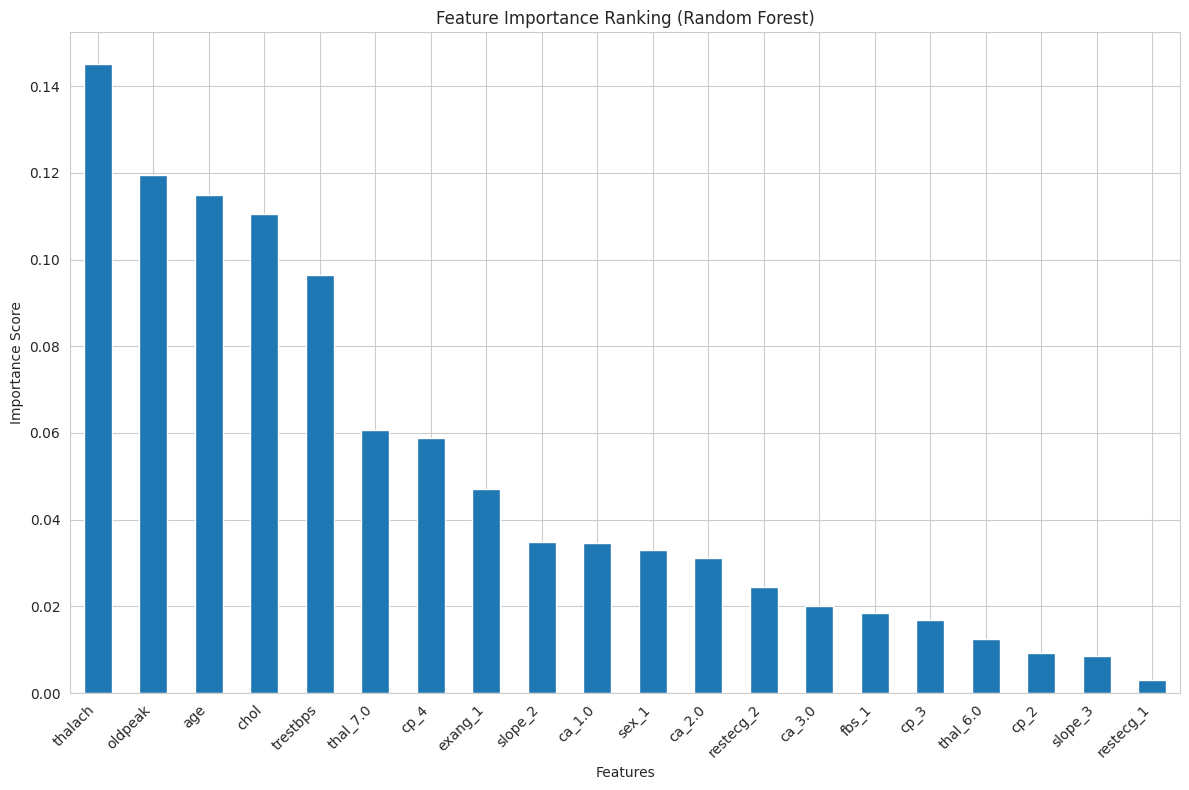

In [ ]:
import matplotlib.pyplot as plt

# Visualize the sorted feature importances
plt.figure(figsize=(12, 8))
sorted_feature_importances.plot(kind='bar')
plt.title('Feature Importance Ranking (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Create a bar plot to visualize the feature importance scores obtained from the Random Forest model, showing the most important features at the top. This provides a clear visual representation of which features were most influential in the model's decision-making process.

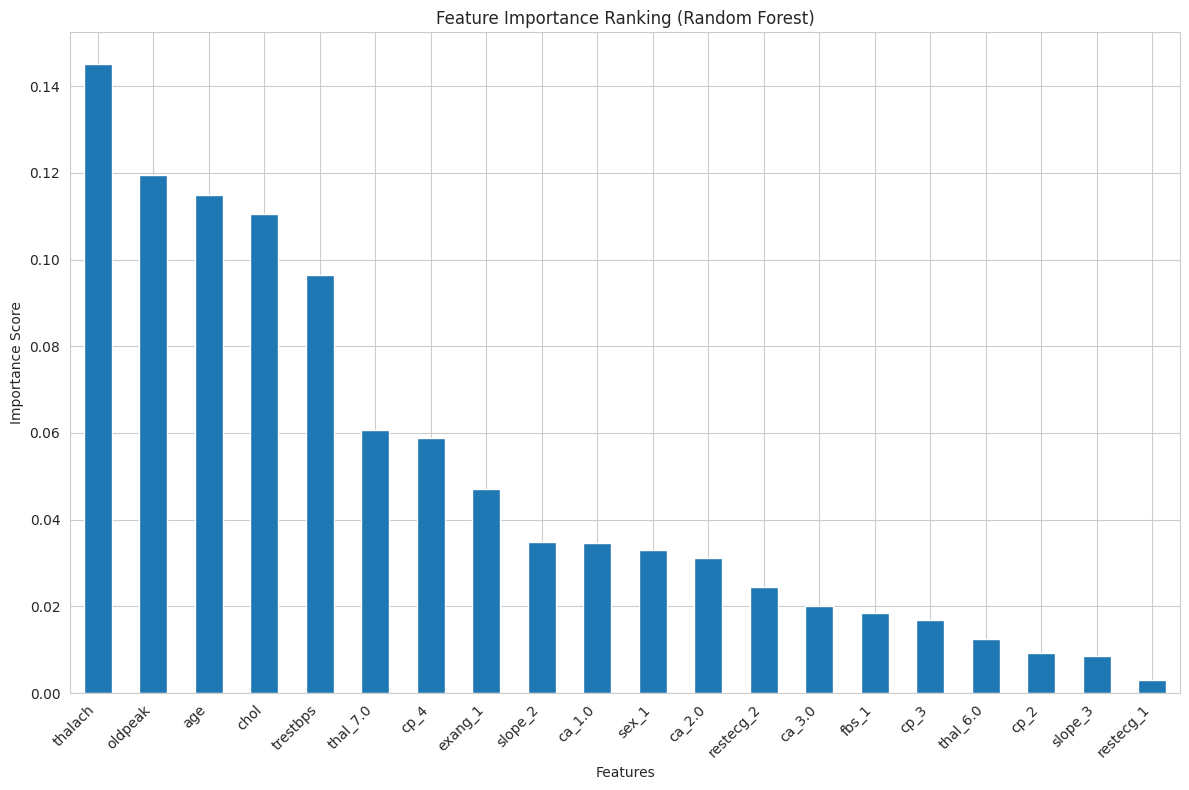

In [ ]:
import matplotlib.pyplot as plt

# Visualize the sorted feature importances
plt.figure(figsize=(12, 8))
sorted_feature_importances.plot(kind='bar')
plt.title('Feature Importance Ranking (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Combine the results from the Random Forest feature importance, RFE, and Chi-Square tests to identify the most relevant features. A common approach is to select features that appear in the top rankings of multiple methods or those with significant p-values from the Chi-Square test. We will then create a new DataFrame containing only these selected features and the target variable.

In [ ]:
# Based on the previous results:
# Feature Importance (Random Forest): thalach, oldpeak, age, chol, trestbps, thal_7.0, cp_4, exang_1, slope_2, ca_1.0 are in the top 10.
# RFE: oldpeak, cp_2, cp_3, cp_4, fbs_1, ca_1.0, ca_2.0, ca_3.0, thal_6.0, thal_7.0 were selected as the top 10 (when selecting 10 features).
# Chi-Square Test (for original categorical features): ca, thal, exang, cp, restecg, slope have significant p-values (typically < 0.05).

# Let's select features that are consistently important or significant across these methods.
# We'll consider features that are in the top 10 of Feature Importance or RFE,
# and categorical features (and their one-hot encoded versions) that were significant in the Chi-Square test.

# Features from Feature Importance (top 10)
fi_features = sorted_feature_importances.head(10).index.tolist()

# Features selected by RFE
rfe_features = selected_features.tolist()

# Categorical features significant from Chi-Square test (p-value < 0.05)
chi2_significant_original_cat_features = chi2_results_sorted[chi2_results_sorted['P-value'] < 0.05].index.tolist()

# Get the one-hot encoded column names for the significant categorical features
chi2_significant_encoded_features = [col for col in X.columns if any(original_col in col for original_col in chi2_significant_original_cat_features)]


# Combine the feature lists, removing duplicates
selected_features_combined = list(set(fi_features + rfe_features + chi2_significant_encoded_features))

# Ensure the target variable 'num' is not in the selected features list
if 'num' in selected_features_combined:
    selected_features_combined.remove('num')

# Create the reduced dataset
df_reduced = df_encoded[selected_features_combined + ['num']]

print("Selected features:")
display(selected_features_combined)

print("\nReduced dataset (first 5 rows):")
display(df_reduced.head())

Selected features:


['cp_2',
 'chol',
 'ca_1.0',
 'thal_6.0',
 'slope_2',
 'slope_3',
 'age',
 'restecg_1',
 'ca_2.0',
 'oldpeak',
 'restecg_2',
 'trestbps',
 'thal_7.0',
 'cp_4',
 'exang_1',
 'thalach',
 'ca_3.0',
 'cp_3']


Reduced dataset (first 5 rows):


,cp_2,chol,ca_1.0,thal_6.0,slope_2,slope_3,age,restecg_1,ca_2.0,oldpeak,restecg_2,trestbps,thal_7.0,cp_4,exang_1,thalach,ca_3.0,cp_3,num
0,False,-0.264900,False,True,False,True,0.948726,False,False,1.087338,True,0.757525,False,False,False,0.017197,False,False,0
1,False,0.760415,False,False,True,False,1.392002,False,False,0.397182,True,1.611220,False,True,True,-1.821905,True,False,2
2,False,-0.342283,False,False,True,False,1.392002,False,True,1.346147,True,-0.665300,True,True,True,-0.902354,False,False,1
3,False,0.063974,False,False,False,True,-1.932564,False,False,2.122573,False,-0.096170,False,False,False,1.637359,False,True,0
4,True,-0.825922,False,False,False,False,-1.489288,False,False,0.310912,True,-0.096170,False,False,False,0.980537,False,False,0
